In [1]:
import os
import sys
sys.path.append("../data/neural_data/")
sys.path.append("../utils/")
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import extract_waveforms as wf
import raw_neural_data as raw
import basic_analysis as basic
import fig6_analysis as analysis
import analysis_neuro as spk
import fig6_plots

In [2]:
# file paths
data_folder = f"../data/neural_data/multi_map/"
save_folder = f"{data_folder}waveform_info/"
if os.path.isdir(save_folder):
    print('save folder exists')
else:
    os.mkdir(save_folder)
session_paths = wf.list_sessions(data_folder)

save folder exists


In [3]:
session_IDs = os.listdir(data_folder)
session_IDs = session_IDs[:-1]

# sort for plotting
session_order = np.asarray([1, 2, 0, 3])
sorted_sessions = []
sorted_paths = []
for idx in session_order:
    sorted_sessions.append(session_IDs[idx])
    sorted_paths.append(session_paths[idx])

# number of maps per session
session_maps = np.asarray([3, 3, 4, 4])

# example cells
ex_cells = np.asarray([
    [529, 528, 95], # Seattle_1010_1
    [521, 519, 402], # Toronto_1111_1
    [341, 313, 249], # Seattle_1006_1
    [252, 250, 163] # Toronto_1117_1
])

In [4]:
''' define epochs for waveform extraction '''
epoch_trials_all = [] # trials
epochs_all = [] # samples
for i, s_id in enumerate(sorted_sessions):  
    # find the epochs
    n_maps = session_maps[i]
    epoch_trials, epoch_times = analysis.choose_epochs(data_folder, s_id, n_maps)
    epoch_trials_all.append(epoch_trials)
    epochs_all.append(epoch_times)
    
    print(f"{s_id}: epochs = {epoch_trials}")    
    
    # save for this session
    path = sorted_paths[i]
#     np.save(f"{path}/{s_id}_epochs.npy", epoch_times)

../data/neural_data/multi_map/Seattle_1010_1/Seattle_1010_1_data.mat
Seattle_1010_1: epochs = [[ 17. 103.]
 [356. 397.]
 [259. 301.]]
../data/neural_data/multi_map/Toronto_1111_1/Toronto_1111_1_data.mat
Toronto_1111_1: epochs = [[192. 203.]
 [  0.  80.]
 [146. 149.]]
../data/neural_data/multi_map/Seattle_1006_1/Seattle_1006_1_data.mat
Seattle_1006_1: epochs = [[137. 236.]
 [116. 136.]
 [ 29.  52.]
 [  0.  28.]]
../data/neural_data/multi_map/Toronto_1117_1/Toronto_1117_1_data.mat
Toronto_1117_1: epochs = [[352. 398.]
 [140. 165.]
 [217. 230.]
 [  0.  33.]]


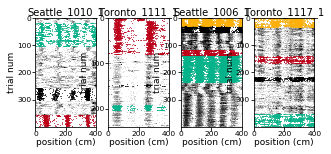

In [11]:
''' spot check epochs '''
f, ax = plt.subplots(1, 4, figsize=(5, 2))
c1 = 'xkcd:scarlet'
c2 = 'xkcd:green blue'
c3 = 'k'
c4 = 'xkcd:saffron'

for s, s_id in enumerate(sorted_sessions):
    session_ID = sorted_sessions[s]
    c_id = ex_cells[s][1]
    n_maps = session_maps[s]
    
    # data params
    d = analysis.load_neural_data(data_folder, session_ID)
    d = analysis.format_neural_data(d, n_maps=n_maps,
                                    filter_stability=False, unstable_thresh=0.25)
    A = d['A']
    B = d['B']
    cells = d['cells']
    ex_trials = epoch_trials_all[s]
    n_epochs = ex_trials.shape[0]
    
    # plotting params
    if n_epochs == 3:
        wf_colors = [c2, c1, c3]
    else:
        wf_colors = [c2, c1, c3, c4]
    assert len(wf_colors) == n_epochs
    PT_SIZE = 0.6

    # get cell indices
    cdx = np.where(cells==c_id)[0][0]
    sdx = B[:, cdx].astype(bool)

    # plot raster, color points for epoch trials
    ax0 = ax[s]
    trials = A[:, 2]
    max_trial = np.max(A[:, 2]) + 1
    ax0.scatter(A[:, 0][sdx], A[:, 2][sdx], color='k', lw=0, s=PT_SIZE, alpha=.1)
    for i in range(n_epochs):
        trial_idx = (trials[sdx] >= ex_trials[i, 0]) & (trials[sdx] <= ex_trials[i, 1])
        ax0.scatter(A[:, 0][sdx][trial_idx], A[:, 2][sdx][trial_idx], 
                   color=wf_colors[i], lw=0, s=PT_SIZE, alpha=0.8)
    ax0.set_xlim([0, 400])
    ylim_ax = [0, max_trial]
    ax0.set_ylim(ylim_ax[::-1])
    ax0.set_yticks(np.arange(0, max_trial, 100))
    ax0.set_xticks([0, 200, 400])
    ax0.set_title(f'{s_id}', fontsize=9, pad=3)
    ax0.tick_params(which='major', labelsize=7.5, pad=0.5)
    ax0.set_xlabel('position (cm)', fontsize=9, labelpad=1)
    if s==0:
        ax0.set_ylabel('trial num', fontsize=9, labelpad=1)
        
f.savefig(f'{save_folder}all_sessions_example_cells.png', dpi=400, bbox_inches='tight')
plt.show()

In [12]:
f.savefig(f'{save_folder}all_sessions_example_cells.png', dpi=400, bbox_inches='tight')

In [13]:
''' save the epoch files '''
for i, s_id in enumerate(sorted_sessions):  
    epoch_times = epochs_all[i]    
    path = sorted_paths[i]
    np.save(f"{path}/{s_id}_epochs.npy", epoch_times)

In [ ]:
''' get the waveforms for each session (AW ran this) '''
# for i in enumerate(session_IDs):
#     wf.run_session(data_folder, i)

In [ ]:
''' 
TODO:
- get the files from oak
- run the waveform extraction code (above)
- check that it worked / debug
- clean up the below code
- transfer bulk to the fig6 analysis and plotting packages
- move remaining code to the fig6 and supp fig notebooks as appropriate
'''

In [24]:
''' choose an example session '''
ex_idx = 2
session_ID = sorted_sessions[ex_idx]
cell_ids = ex_cells[ex_idx]
n_maps = session_maps[ex_idx]

In [25]:
''' load the data and divide by map '''
d = analysis.load_neural_data(data_folder, session_ID)
d = analysis.format_neural_data(d, n_maps=n_maps,
                                filter_stability=False, unstable_thresh=0.25)
sp = raw.load_np_data(data_folder, session_ID)
d['sp'] = sp
print(f'loaded data for {session_ID}')

../data/neural_data/multi_map/Seattle_1006_1/Seattle_1006_1_data.mat
loaded data for Seattle_1006_1


In [26]:
''' get the waveform data
epochs : ndarray, shape (num_epochs, 2) 
    time associated with the start and end of each epoch
waveform_avg : ndarray, shape (num_epochs, num_cells, num_channels, num_samples)
    average waveforms for each epoch
waveform_std : corresponding standard deviations
'''
path = sorted_paths[ex_idx]
d['waveform_avg'] = np.load(f'{path}/{session_ID}_mean_waveforms.npy')
d['waveform_std'] = np.load(f'{path}/{session_ID}_stddev_waveforms.npy')

# get the epochs in ks samples and convert to trial numbers
d['epochs'] = np.load(f'{path}/{session_ID}_epochs.npy')
d['epoch_trials'] = analysis.samples_to_trials(d)

In [27]:
''' get the channel associated with each cell:
- get cell depth : sp['spike_depth']
- find the channel closest in depth : sp['ycoords']
'''
cells = d['cells']
sp = d['sp']
depth_unsorted = sp['spike_depth'].copy()

# get all good cells
cgs = sp['cgs'].copy()
cids = sp['cids'].copy()
good_cells = cids[cgs == 2]

# get depth for each MEC cell
depth = np.zeros(cells.shape[0])
for i, c in enumerate(cells):
    depth[i] = depth_unsorted[good_cells==c]

# get nearest channel
# there are 385 channels and 379 ycoords, so I'm calling those the middle 379 channels
channel_depths = sp['ycoords'].copy()
channels = np.zeros(cells.shape[0])
for i, y in enumerate(depth):
    channels[i] = 3 + np.argmin(np.abs(channel_depths - y))
d['cell_channels'] = channels.astype(int)

In [28]:
epoch_trials = d['epoch_trials']
epoch_trials

array([[137., 235.],
       [116., 136.],
       [ 29.,  52.],
       [  0.,  28.]])

In [29]:
''' compare waveforms across maps '''
waveform_avg = d['waveform_avg'].copy()
waveform_std = d['waveform_std'].copy()
n_epochs, n_cells, n_channels, n_samples = waveform_avg.shape
print(f'{session_ID}: n cells = {n_cells}, n maps = {n_epochs}')

# for each cell, grab the avg waveforms for just the 20 best channels
cell_channels = d['cell_channels'].copy()
wf_avg = np.zeros((n_epochs, n_cells, 20, n_samples))
for i, ch in enumerate(cell_channels):
    if ch < 10:
        wf_avg[:, i, :, :] = waveform_avg[:, i, :20, :]
    elif ch > 375:
        wf_avg[:, i, :, :] = waveform_avg[:, i, 365:, :]
    else:
        wf_avg[:, i, :, :] = waveform_avg[:, i, ch-10:ch+10, :]

# compute correlation for flattened vectors
avg_corr = np.zeros(n_cells)
flat_wf_avg = np.reshape(wf_avg, (n_epochs, n_cells, -1))
avg_corr = np.full(n_cells, np.nan)
for c in range(n_cells):
    cell_wf_avg = flat_wf_avg[:, c, :]
    corr_vec = np.abs(pdist(cell_wf_avg, 'correlation')-1)
    avg_corr[c] = np.nanmean(corr_vec)
    
# get quartiles and median
pct_5 = np.percentile(avg_corr, 5)
pct_95 = np.percentile(avg_corr, 95)
med_corr = np.median(avg_corr)

d['correlations'] = avg_corr
print(f'across all cells: median correlation = {med_corr:.4}, 5th percentile = {pct_5:.4}')

Seattle_1006_1: n cells = 196, n maps = 4
across all cells: median correlation = 0.9954, 5th percentile = 0.9888


In [30]:
''' plot example rasters and waveforms '''
c1 = 'xkcd:scarlet'
c2 = 'xkcd:green blue'
c3 = 'k'
c4 = 'xkcd:saffron'
wf_colors = [c2, c1, c3, c4]

In [31]:
ex_trials = d['epoch_trials']
ex_trials.shape[0]

4

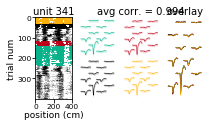

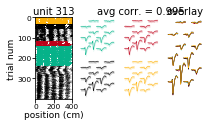

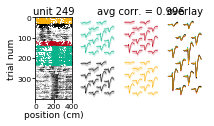

In [32]:
for c_id in cell_ids:
    # data params
    A = d['A']
    B = d['B']
    cells = d['cells']
    waveform_avg = d['waveform_avg'].copy()
    waveform_std = d['waveform_std'].copy()
    n_epochs, n_cells, n_channels, n_samples = waveform_avg.shape
    n_pairs = n_epochs//2
    ex_trials = d['epoch_trials']
    assert(n_epochs == ex_trials.shape[0])

    # plotting params
    gs = gridspec.GridSpec(2, n_pairs+2, wspace=0.2, hspace=0)
    f = plt.figure(figsize=((n_pairs)*1.5, 1.5))
    if n_epochs == 3:
        wf_colors = [c2, c1, c3]
    assert len(wf_colors) == n_epochs
    PT_SIZE = 0.6

    # get cell indices
    cdx = np.where(cells==c_id)[0][0]
    sdx = B[:, cdx].astype(bool)

    # compute unfiltered avg correlation
    cell_channels = d['cell_channels'].copy()
    wf_avg = np.zeros((n_epochs, n_cells, 20, n_samples))
    for i, ch in enumerate(cell_channels):
        if ch < 10:
            wf_avg[:, i, :, :] = waveform_avg[:, i, :20, :]
        elif ch > 375:
            wf_avg[:, i, :, :] = waveform_avg[:, i, 365:, :]
        else:
            wf_avg[:, i, :, :] = waveform_avg[:, i, ch-10:ch+10, :]
    avg_corr = np.zeros(n_cells)
    for p in range(n_pairs):
        i = 2*p
        flat_wf_avg_pre = np.reshape(wf_avg[i, :, :, :], (n_cells, -1))
        flat_wf_avg_post = np.reshape(wf_avg[i+1, :, :, :], (n_cells, -1))
        flat_wf_avg = np.row_stack((flat_wf_avg_pre, flat_wf_avg_post))
        corr_vec = np.abs(pdist(flat_wf_avg, 'correlation')-1)
        correlations = np.diagonal(squareform(corr_vec), offset=n_cells)
        avg_corr += correlations
    avg_corr = avg_corr/n_pairs

    # plot raster, color points for example waveforms
    ax0 = plt.subplot(gs[:, 0])
    trials = A[:, 2]
    max_trial = np.max(A[:, 2]) + 1
    ax0.scatter(A[:, 0][sdx], A[:, 2][sdx], color='k', lw=0, s=PT_SIZE, alpha=.1)
    for i in range(n_epochs):
        trial_idx = (trials[sdx] >= ex_trials[i, 0]) & (trials[sdx] <= ex_trials[i, 1])
        ax0.scatter(A[:, 0][sdx][trial_idx], A[:, 2][sdx][trial_idx], 
                   color=wf_colors[i], lw=0, s=PT_SIZE, alpha=0.8)
    ax0.set_xlim([0, 400])
    ylim_ax = [0, max_trial]
    ax0.set_ylim(ylim_ax[::-1])
    ax0.set_yticks(np.arange(0, max_trial, 100))
    ax0.set_xticks([0, 200, 400])
    ax0.set_title('unit {}'.format(c_id), fontsize=10, pad=3)
    ax0.tick_params(which='major', labelsize=7.5, pad=0.5)
    ax0.set_xlabel('position (cm)', fontsize=9, labelpad=1)
    ax0.set_ylabel('trial num', fontsize=9, labelpad=1)

    # plot example waveforms
    ax2 = plt.subplot(gs[:, n_pairs+1])
    for i in range(n_epochs):
        if i < n_pairs:
            ax1 = plt.subplot(gs[0, i+1])
        else:
            ax1 = plt.subplot(gs[1, i-n_pairs+1])
        fig6_plots.plot_waveforms(d, c_id, i, ax1, wf_colors[i])
        fig6_plots.plot_waveforms(d, c_id, i, ax2, wf_colors[i], plot_std=False)
        if i == n_pairs//2:
            ax1.set_title('avg corr. = {}'.format(np.round(avg_corr[cdx], 3)), 
                          fontsize=10, pad=3, )
    ax2.tick_params(which='major', labelsize=7.5, pad=0.5)
    ax2.set_title('overlay', fontsize=10, pad=3)

    f.savefig(f'{save_folder}{session_ID}_example_cell_{c_id}.png', dpi=400, bbox_inches='tight')
    plt.show()

In [13]:
'''
Params are chosen to match Low et al. as best as possible.

To extract waveforms we need:
epoch_times : ndarray, shape (num_epochs, 2) 
    time associated with the start and end of each epoch
    choose trial blocks to analyze (stable, 10 or more trials)
    get the start and end times of those blocks
    save as "epochs.npy"
cell_ids : ndarray, shape (num_cells,)
    which cells to analyze - probably just do all of them
    save as "MEC_cellIDs.npy"
spikes_per_epoch : int
    max number of spikes to extract (1000)
neuropixels output file:
    "{session_id}_imec0"




'''

'\nParams are chosen to match Low et al. as best as possible.\n\nTo extract waveforms we need:\nepoch_times : ndarray, shape (num_epochs, 2) \n    time associated with the start and end of each epoch\n    choose trial blocks to analyze (stable, 10 or more trials)\n    get the start and end times of those blocks\n    save as "epochs.npy"\ncell_ids : ndarray, shape (num_cells,)\n    which cells to analyze - probably just do all of them\n    save as "MEC_cellIDs.npy"\nspikes_per_epoch : int\n    max number of spikes to extract (1000)\nneuropixels output file:\n    "{session_id}_imec0"\n\n\n\n\n'